<a href="https://colab.research.google.com/github/khalil-alexander/get_forecast/blob/main/FuturePositionISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="red"> Pip install Astropy in google colab <font/>
### <font color="Green"> We install astropy in order to convert kilometre to longitatide later <font/>

In [1]:
!pip install astropy

## <font color="red"> Install Moudles in google colab <font/>

In [2]:
from astropy import coordinates as coord
from astropy import units as u
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle

In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import requests as reqs
import xml.etree.ElementTree as ET
import io
import pprint
import json
import datetime

In [4]:
from datetime import datetime
import datetime as dt
from datetime import timezone

In [5]:
import xarray as xr

## <font color="red"> Converting coordinates to Latitude and Longitude ISS</font>
### <font color="green"> Using astropy we were able to convery kilometre to longitude and latitude. <font/>

In [6]:
now = Time("2024-03-07 00:46:00.000", scale='utc')
xyz = [1155.746046202530, -6632.420367726780, 953.533229633281]
cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)



gcrs = coord.GCRS(cartrep, obstime = now)
itrs = gcrs.transform_to(coord.ITRS(obstime = now))
loc = coord.EarthLocation(*itrs.cartesian.xyz)

print(loc.lat, loc.lon, loc.height)

8d07m57.90103915s 103d26m20.85144985s 421.8445702007271 km


## <font color="red"> Creating functions to clean up Latitude and Longitude ISS</font>

### <font color="green">Create an empty dateframe for functions

### <font color="green">Create two function that changes km to lat/lon


In [7]:
col_name = ['Date','x units(km)','y units(km)','z units(km)','x_dot(km/s)','y_dot(km/s)','z_dot(km/s)']
# Challenge to have the columns read under beautiful soup
xml_df = pd.DataFrame(columns=col_name)
xml_df

,Date,x units(km),y units(km),z units(km),x_dot(km/s),y_dot(km/s),z_dot(km/s)


In [8]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [9]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




## <font color="red"> read_xml_DateFrame
### <font color="green">A function that reads an xml file and returns the specfic position the iss is at during different time.

In [10]:
def read_xml_DataFrame(url):
    """
    Do web scraping from an XML file to obtain time the International Space
    Station will be at a specfic postion and the speed it is going at.

    Parameters
    ----------
    url : String
        The url of the data in XML format you want to extract from.

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the time the International Space Station is at
        a specfic position and the speed it is traveling.
    """
    # Get the xml request
    xml = reqs.get(url)

    # Use BeautifulSoup to Organize the XML file
    soup = BeautifulSoup(xml.content,"lxml")

    # Finds all the instances 'statevector' appeared in the xml file
    state_tag = soup.find_all('statevector')

    col_name = ['Date','x units(km)',
                'y units(km)','z units(km)',
                'x_dot(km/s)',
                'y_dot(km/s)','z_dot(km/s)']
    df = pd.DataFrame(columns=col_name)

    #Loops thorugh all elements to add rows in the empty xml_df
    for element in state_tag:
        # Turns element into text and splits the '\n'
        element = element.text.split('\n')
        # Deletes First empty String
        element.pop(0)
        # Deletes Last empty Sting
        element.pop(-1)
        # Removes the 'Z' in the elements first index
        element[0] = element[0][:-1]

        # Appending list into DataFrame by adding 1 row to the DataFrame
        #df = xml_df.append(pd.DataFrame(element, columns=col_name), ignore_index=True)
        df.loc[len(df)] = element


    # Turns the "Date" collumn into a Datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%jT%H:%M:%S.%f')
    # Sets the "Date" collumn into a Datetime object
    #df.set_index("Date", inplace=True)

    # Returns the Dataframe
    return df

In [11]:
xml_url = "https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml"
%time df = read_xml_DataFrame(xml_url)

<ipython-input-10-ea97148a76b9>:21: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(xml.content,"lxml")


CPU times: user 10.4 s, sys: 141 ms, total: 10.5 s
Wall time: 11.2 s


In [12]:
df

,Date,x units(km),y units(km),z units(km),x_dot(km/s),y_dot(km/s),z_dot(km/s)
0,2024-12-09 12:00:00,-1652.7463421948501,4395.8815000702998,-4909.1717348923903,-7.2908956842462498,-0.13615858805302999,2.33733423133949
1,2024-12-09 12:04:00,-3321.2944418473899,4203.94886381795,-4176.2363511959002,-6.5286961852710599,-1.4538256986054301,3.7334189886023199
2,2024-12-09 12:08:00,-4748.3383115019897,3706.3747371425902,-3138.8149190019199,-5.2903993132728697,-2.6675993424939999,4.8590838224203496
3,2024-12-09 12:12:00,-5829.6339441926402,2938.9506556475399,-1872.2215759620899,-3.6649357567155598,-3.6887050840348898,5.6312824230514904
4,2024-12-09 12:16:00,-6485.93127828048,1957.2855852759401,-468.76765373474802,-1.7704679716077301,-4.4418526329088497,5.9924023519317204
...,...,...,...,...,...,...,...
5931,2024-12-24 11:45:00,-2772.48102148318,-4936.5256744617,3754.4788360662701,3.5659744152822501,-5.2649704092882796,-4.2724466650143196
5932,2024-12-24 11:49:00,-1826.22081425897,-6005.23861306049,2604.66498165543,4.27139828167146,-3.5865547444380499,-5.25069125904401
5933,2024-12-24 11:53:00,-747.12417128956895,-6637.1429290016404,1264.8580507593099,4.6661571052558104,-1.6471887948936099,-5.8459904046046596
5934,2024-12-24 11:57:00,386.31372604792398,-6786.3248725805697,-167.20734433483599,4.7214973206748203,0.41143151775853998,-6.0148175475239896


#### <font color="reeee">Adds latitude and longitude to the Data Frame

In [13]:
%time df[['lat','lon']] = df.apply(get_latlon, axis=1, result_type='expand')

CPU times: user 56.1 s, sys: 1 s, total: 57.1 s
Wall time: 56.8 s


## <font color="red">Confrim if lat is below 50 and above -50
### <font color="green">We do this because the International Space Station does not travel past 50 and -50 degrees latitude.

### <font color="green">verify_latitude function
- <font color="blue">Returns the min and max latitude in a tuple so the observer can see if the latitude matches the International Space Station path.

In [14]:
def check_latitude(df: pd.DataFrame):
    """
    Gives the minimum and maximum latitude of the path the ISS travels in a
    DataFrame.

    Parameters
    ----------
    df : Pandas Dataframe
        The url of the data in XML format you want to extract from.

    Return
    ------
    df : Tuple
        Returns df max and min latitude.
    """
    return df['lat'].min(), df['lat'].max()

In [15]:
check_latitude(df)

(-51.794851625863934, 51.79425948149588)

In [16]:
df = df[['Date','lat','lon']]

In [17]:
df

,Date,lat,lon
0,2024-12-09 12:00:00,-46.496357,-147.934821
1,2024-12-09 12:04:00,-38.195751,-131.181758
2,2024-12-09 12:08:00,-27.780065,-118.428372
3,2024-12-09 12:12:00,-16.221147,-108.184393
4,2024-12-09 12:16:00,-4.116189,-99.209523
...,...,...,...
5931,2024-12-24 11:45:00,33.645639,-28.826392
5932,2024-12-24 11:49:00,22.622287,-17.399482
5933,2024-12-24 11:53:00,10.771945,-7.881247
5934,2024-12-24 11:57:00,-1.412143,0.826186


## <font color="red">Functions

### 1. <font color="green">obtain_future_date
- <font color="blue">A function where you take the have argurements Pandas Dataframe and nhours.
The function takes the current time and adds in by nhours which the default is three. You will pass in a Pandas dataframe that will take the future values between startdate and 24 hours ahead.

### 2. <font color="green">future_dates
 - <font color="blue">A function where you take the have argurements Pandas Dataframe. The function takes the current time and adds in by three hours.


In [18]:
def obtain_future_date(df: pd.DataFrame, nhours: int=3):
    """
    Collects future position of the ISS with nhours from current time and 6
    hours ahead of nhours

    Parameters
    ----------
    df : Pandas Dataframe
        Dataframe which contains a column with datetime objects.

    nhours: Int
        Number of hours you want to start collecting data from current time.

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the time the International Space Station
        from current time + nhours to 6 hours ahead.
    """
    # String of the current time of day now
    start_date = dt.datetime.now() + dt.timedelta(hours=nhours)
    #end_date = start_date + dt.timedelta(hours=24)
    # Turns the date from a string object to a datetime object
    start_date = start_date.strftime("%m/%d/%Y %H:%M:%S")
    start_date = pd.to_datetime(start_date, format='%m/%d/%Y %H:%M:%S')

    end_date = start_date + dt.timedelta(hours=6)
    #end_date = end_date.strftime("%m/%d/%Y %H:%M:%S")
    #end_date = pd.to_datetime(start_date, format='%m/%d/%Y %H:%M:%S')
    #return (start_date, end_date)

    return df[(start_date <= df['Date']) & (end_date >= df['Date'])]

In [59]:
df1 = obtain_future_date(df)
df1.index = range(len(df1))

In [60]:
df1

,Date,lat,lon
0,2024-12-12 21:32:00,-5.987524,-70.349254
1,2024-12-12 21:36:00,-18.012082,-61.272167
2,2024-12-12 21:40:00,-29.421045,-50.764470
3,2024-12-12 21:44:00,-39.579790,-37.539760
4,2024-12-12 21:48:00,-47.448744,-20.118405
...,...,...,...
85,2024-12-13 03:12:00,46.104618,73.406086
86,2024-12-13 03:16:00,51.086895,94.670991
87,2024-12-13 03:20:00,51.181139,118.425846
88,2024-12-13 03:24:00,46.360161,139.831296


In [61]:
df1.rename(columns={'Date': 't',}, inplace=True)

<ipython-input-61-f5fb0ce3a68a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={'Date': 't',}, inplace=True)


## EXPLORE

In [62]:
df1

,t,lat,lon
0,2024-12-12 21:32:00,-5.987524,-70.349254
1,2024-12-12 21:36:00,-18.012082,-61.272167
2,2024-12-12 21:40:00,-29.421045,-50.764470
3,2024-12-12 21:44:00,-39.579790,-37.539760
4,2024-12-12 21:48:00,-47.448744,-20.118405
...,...,...,...
85,2024-12-13 03:12:00,46.104618,73.406086
86,2024-12-13 03:16:00,51.086895,94.670991
87,2024-12-13 03:20:00,51.181139,118.425846
88,2024-12-13 03:24:00,46.360161,139.831296


In [63]:
def get_orbit(df: pd.DataFrame):
    count = 0
    temp_df = df['lon']

    for i in range(len(temp_df)-1):
        if (temp_df[i] > 0) and (temp_df[i+1] < 0):
            count += 1
            if count == 2:
                new_df = df.loc[low:i]
                return new_df
            low = i+1

In [64]:
df_orbit = get_orbit(df1)

In [66]:
df_orbit.set_index('t', inplace=True)

In [67]:
df_orbit

,lat,lon
t,,
2024-12-12 22:44:00,48.764454,-157.286024
2024-12-12 22:48:00,41.598210,-138.732797
2024-12-12 22:52:00,31.829137,-124.665195
2024-12-12 22:56:00,20.620164,-113.660788
2024-12-12 23:00:00,8.683010,-104.352568
2024-12-12 23:04:00,-3.519225,-95.689641
2024-12-12 23:08:00,-15.611704,-86.774375
2024-12-12 23:12:00,-27.186492,-76.648719
2024-12-12 23:16:00,-37.665265,-64.094427


In [68]:
for element in df_orbit['lon']:
    print(element)


-157.28602410373753
-138.73279733421896
-124.66519540497947
-113.66078846289506
-104.35256815058486
-95.68964124854728
-86.77437454534947
-76.64871868971994
-64.0944269904727
-47.6252311367561
-26.42617804124791
-2.725089244514095
18.67072610268925
35.355948220598826
48.06363330612526
58.283045665245496
67.24953917893367
75.9322869508136
85.23265423708436
96.19894865006131
110.19290893593549
128.6470824608757
151.4268558840547
174.77711387214563


In [69]:
lon_df = df_orbit['lon']

for i in range(len(lon_df)-1):
    print(lon_df[i], lon_df[i+1] )

-157.28602410373753 -138.73279733421896
-138.73279733421896 -124.66519540497947
-124.66519540497947 -113.66078846289506
-113.66078846289506 -104.35256815058486
-104.35256815058486 -95.68964124854728
-95.68964124854728 -86.77437454534947
-86.77437454534947 -76.64871868971994
-76.64871868971994 -64.0944269904727
-64.0944269904727 -47.6252311367561
-47.6252311367561 -26.42617804124791
-26.42617804124791 -2.725089244514095
-2.725089244514095 18.67072610268925
18.67072610268925 35.355948220598826
35.355948220598826 48.06363330612526
48.06363330612526 58.283045665245496
58.283045665245496 67.24953917893367
67.24953917893367 75.9322869508136
75.9322869508136 85.23265423708436
85.23265423708436 96.19894865006131
96.19894865006131 110.19290893593549
110.19290893593549 128.6470824608757
128.6470824608757 151.4268558840547
151.4268558840547 174.77711387214563


<ipython-input-69-6e07b96e3904>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(lon_df[i], lon_df[i+1] )


In [70]:
def count_orbit(df: pd.DataFrame):
    count = 0
    temp_df = df['lon']

    for i in range(len(temp_df)-1):
        if (temp_df[i] > 0) and (temp_df[i+1] < 0):
            count += 1
            print(i, temp_df[i], temp_df[i+1])
    return count

In [71]:
orbit = count_orbit(df_orbit)

<ipython-input-70-ce539bacc193>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (temp_df[i] > 0) and (temp_df[i+1] < 0):


In [72]:
orbit

0

In [73]:
df_orbit

,lat,lon
t,,
2024-12-12 22:44:00,48.764454,-157.286024
2024-12-12 22:48:00,41.598210,-138.732797
2024-12-12 22:52:00,31.829137,-124.665195
2024-12-12 22:56:00,20.620164,-113.660788
2024-12-12 23:00:00,8.683010,-104.352568
2024-12-12 23:04:00,-3.519225,-95.689641
2024-12-12 23:08:00,-15.611704,-86.774375
2024-12-12 23:12:00,-27.186492,-76.648719
2024-12-12 23:16:00,-37.665265,-64.094427


## Getting full orbit

## xarray

In [ ]:
#type(dt.datetime.now() + dt.timedelta(hours=3))

In [74]:
def changeto_xarray(df):
    """
    Using a previous DataFrame and converting it into an Xarray.

    Parameters
    ----------
    df : Pandas DataFrame



    Return
    ------
    ds : Xarray
        The Xarray containing the collected following data variables:
        Date, Latitude(lat), and Longitude(lon).

    """

    #Converts the hourly  DateTime object to an Xarray object which return a more percise time with it's weather conditions
    ds = df.to_xarray()

    return ds

In [81]:
len(df_orbit)

24

In [82]:
test_ds = changeto_xarray(df_orbit)

In [83]:
test_ds

<xarray.Dataset> Size: 576B
Dimensions:  (t: 24)
Coordinates:
  * t        (t) datetime64[ns] 192B 2024-12-12T22:44:00 ... 2024-12-13T00:16:00
Data variables:
    lat      (t) float64 192B 48.76 41.6 31.83 20.62 ... 41.38 48.63 51.76 49.76
    lon      (t) float64 192B -157.3 -138.7 -124.7 -113.7 ... 128.6 151.4 174.8

In [85]:
df_orbit

,lat,lon
t,,
2024-12-12 22:44:00,48.764454,-157.286024
2024-12-12 22:48:00,41.598210,-138.732797
2024-12-12 22:52:00,31.829137,-124.665195
2024-12-12 22:56:00,20.620164,-113.660788
2024-12-12 23:00:00,8.683010,-104.352568
2024-12-12 23:04:00,-3.519225,-95.689641
2024-12-12 23:08:00,-15.611704,-86.774375
2024-12-12 23:12:00,-27.186492,-76.648719
2024-12-12 23:16:00,-37.665265,-64.094427


In [86]:
#start_date =
df_orbit.index

DatetimeIndex(['2024-12-12 22:44:00', '2024-12-12 22:48:00',
               '2024-12-12 22:52:00', '2024-12-12 22:56:00',
               '2024-12-12 23:00:00', '2024-12-12 23:04:00',
               '2024-12-12 23:08:00', '2024-12-12 23:12:00',
               '2024-12-12 23:16:00', '2024-12-12 23:20:00',
               '2024-12-12 23:24:00', '2024-12-12 23:28:00',
               '2024-12-12 23:32:00', '2024-12-12 23:36:00',
               '2024-12-12 23:40:00', '2024-12-12 23:44:00',
               '2024-12-12 23:48:00', '2024-12-12 23:52:00',
               '2024-12-12 23:56:00', '2024-12-13 00:00:00',
               '2024-12-13 00:04:00', '2024-12-13 00:08:00',
               '2024-12-13 00:12:00', '2024-12-13 00:16:00'],
              dtype='datetime64[ns]', name='t', freq=None)

In [87]:
df_orbit.index[0]

Timestamp('2024-12-12 22:44:00')

In [88]:
df_orbit.index[0].dt.strftime('%Y-%m-%dT%H:%M:%S')

AttributeError: 'Timestamp' object has no attribute 'dt'

In [ ]:
start_date =

In [113]:
# Create a date range for interpolation

# Start date + 5 seconds
# End date - 5 seconds

new_dates = pd.date_range('2024-12-12T22:44:05.00', '2024-12-13T00:15:55.00', freq='20s')

In [114]:
new_dates

DatetimeIndex(['2024-12-12 22:44:05', '2024-12-12 22:44:25',
               '2024-12-12 22:44:45', '2024-12-12 22:45:05',
               '2024-12-12 22:45:25', '2024-12-12 22:45:45',
               '2024-12-12 22:46:05', '2024-12-12 22:46:25',
               '2024-12-12 22:46:45', '2024-12-12 22:47:05',
               ...
               '2024-12-13 00:12:45', '2024-12-13 00:13:05',
               '2024-12-13 00:13:25', '2024-12-13 00:13:45',
               '2024-12-13 00:14:05', '2024-12-13 00:14:25',
               '2024-12-13 00:14:45', '2024-12-13 00:15:05',
               '2024-12-13 00:15:25', '2024-12-13 00:15:45'],
              dtype='datetime64[ns]', length=276, freq='20s')

In [115]:
test_ds

<xarray.Dataset> Size: 576B
Dimensions:  (t: 24)
Coordinates:
  * t        (t) datetime64[ns] 192B 2024-12-12T22:44:00 ... 2024-12-13T00:16:00
Data variables:
    lat      (t) float64 192B 48.76 41.6 31.83 20.62 ... 41.38 48.63 51.76 49.76
    lon      (t) float64 192B -157.3 -138.7 -124.7 -113.7 ... 128.6 151.4 174.8

In [116]:
# Interpolate data to the new date range using linear interpolation

interpolated_data = test_ds.interp(t=new_dates, method='linear')



print(interpolated_data)

<xarray.Dataset> Size: 7kB
Dimensions:  (t: 276)
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-12T22:44:05 ... 2024-12-13T00:15:45
Data variables:
    lat      (t) float64 2kB 48.62 48.02 47.42 46.82 ... 50.38 50.22 50.05 49.88
    lon      (t) float64 2kB -156.9 -155.4 -153.8 -152.3 ... 169.4 171.4 173.3


In [117]:
interpolated_data

<xarray.Dataset> Size: 7kB
Dimensions:  (t: 276)
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-12T22:44:05 ... 2024-12-13T00:15:45
Data variables:
    lat      (t) float64 2kB 48.62 48.02 47.42 46.82 ... 50.38 50.22 50.05 49.88
    lon      (t) float64 2kB -156.9 -155.4 -153.8 -152.3 ... 169.4 171.4 173.3

In [118]:
interpolated_data.lon

<xarray.DataArray 'lon' (t: 276)> Size: 2kB
array([-156.89949855, -155.35339632, -153.80729408, -152.26119185,
       -150.71508962, -149.16898739, -147.62288516, -146.07678293,
       -144.5306807 , -142.98457847, -141.43847624, -139.89237401,
       -138.43972229, -137.26742213, -136.09512197, -134.92282181,
       -133.75052165, -132.57822149, -131.40592133, -130.23362117,
       -129.06132101, -127.88902085, -126.71672069, -125.54442053,
       -124.43593693, -123.51890302, -122.6018691 , -121.68483519,
       -120.76780128, -119.85076737, -118.93373346, -118.01669954,
       -117.09966563, -116.18263172, -115.26559781, -114.3485639 ,
       -113.46686721, -112.69118218, -111.91549715, -111.13981213,
       -110.3641271 , -109.58844208, -108.81275705, -108.03707202,
       -107.261387  , -106.48570197, -105.71001695, -104.93433192,
       -104.17209051, -103.45017993, -102.72826936, -102.00635878,
       -101.28444821, -100.56253763,  -99.84062706,  -99.11871648,
        -98.39680591,  -97.67489533,  -96.95298476,  -96.23107418,
        -95.50390653,  -94.76096763,  -94.01802874,  -93.27508985,
        -92.53215096,  -91.78921207,  -91.04627317,  -90.30333428,
        -89.56039539,  -88.8174565 ,  -88.07451761,  -87.33157871,
        -86.56342338,  -85.71961873,  -84.87581407,  -84.03200942,
        -83.18820476,  -82.34440011,  -81.50059545,  -80.6567908 ,
...
         70.32467901,   71.04824133,   71.77180364,   72.49536596,
         73.21892827,   73.94249059,   74.6660529 ,   75.38961522,
         76.1260446 ,   76.90107521,   77.67610582,   78.45113642,
         79.22616703,   80.00119764,   80.77622825,   81.55125885,
         82.32628946,   83.10132007,   83.87635067,   84.65138128,
         85.4611187 ,   86.37497657,   87.28883444,   88.20269231,
         89.11655018,   90.03040804,   90.94426591,   91.85812378,
         92.77198165,   93.68583951,   94.59969738,   95.51355525,
         96.49048949,   97.65665285,   98.8228162 ,   99.98897956,
        101.15514292,  102.32130628,  103.48746963,  104.65363299,
        105.81979635,  106.9859597 ,  108.15212306,  109.31828642,
        110.57737088,  112.11521868,  113.65306647,  115.19091427,
        116.72876206,  118.26660985,  119.80445765,  121.34230544,
        122.88015323,  124.41800103,  125.95584882,  127.49369662,
        129.12166107,  131.01997553,  132.91828998,  134.81660443,
        136.71491888,  138.61323333,  140.51154779,  142.40986224,
        144.30817669,  146.20649114,  148.10480559,  150.00312005,
        151.91331959,  153.85917442,  155.80502926,  157.75088409,
        159.69673892,  161.64259375,  163.58844859,  165.53430342,
        167.48015825,  169.42601308,  171.37186792,  173.31772275])
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-12T22:44:05 ... 2024-12-13T00:15:45

In [119]:
interpolated_data.lat

<xarray.DataArray 'lat' (t: 276)> Size: 2kB
array([ 48.61515678,  48.0179698 ,  47.42078282,  46.82359584,
        46.22640886,  45.62922188,  45.0320349 ,  44.43484791,
        43.83766093,  43.24047395,  42.64328697,  42.04609999,
        41.3946874 ,  40.58059797,  39.76650854,  38.95241912,
        38.13832969,  37.32424026,  36.51015083,  35.69606141,
        34.88197198,  34.06788255,  33.25379312,  32.4397037 ,
        31.59561635,  30.66153527,  29.72745419,  28.7933731 ,
        27.85929202,  26.92521093,  25.99112985,  25.05704877,
        24.12296768,  23.1888866 ,  22.25480552,  21.32072443,
        20.37147291,  19.37671008,  18.38194725,  17.38718441,
        16.39242158,  15.39765875,  14.40289591,  13.40813308,
        12.41337025,  11.41860742,  10.42384458,   9.42908175,
         8.4287964 ,   7.41194351,   6.39509062,   5.37823773,
         4.36138484,   3.34453194,   2.32767905,   1.31082616,
         0.29397327,  -0.72287962,  -1.73973251,  -2.75658541,
        -3.77115172,  -4.77885828,  -5.78656485,  -6.79427141,
        -7.80197798,  -8.80968454,  -9.81739111, -10.82509767,
       -11.83280424, -12.8405108 , -13.84821737, -14.85592393,
       -15.85284528, -16.81741097, -17.78197667, -18.74654237,
       -19.71110806, -20.67567376, -21.64023945, -22.60480515,
...
         0.39758241,   1.41727412,   2.43696584,   3.45665755,
         4.47634927,   5.49604098,   6.5157327 ,   7.53542441,
         8.54979319,   9.54819313,  10.54659307,  11.54499301,
        12.54339295,  13.54179289,  14.54019283,  15.53859278,
        16.53699272,  17.53539266,  18.5337926 ,  19.53219254,
        20.51560948,  21.45407742,  22.39254536,  23.3310133 ,
        24.26948124,  25.20794918,  26.14641713,  27.08488507,
        28.02335301,  28.96182095,  29.90028889,  30.83875683,
        31.74751023,  32.56712005,  33.38672986,  34.20633967,
        35.02594948,  35.84555929,  36.6651691 ,  37.48477891,
        38.30438872,  39.12399854,  39.94360835,  40.76321816,
        41.52909289,  42.1337624 ,  42.7384319 ,  43.3431014 ,
        43.94777091,  44.55244041,  45.15710992,  45.76177942,
        46.36644893,  46.97111843,  47.57578794,  48.18045744,
        48.69900917,  48.95920755,  49.21940594,  49.47960433,
        49.73980271,  50.0000011 ,  50.26019949,  50.52039787,
        50.78059626,  51.04079465,  51.30099303,  51.56119142,
        51.71472621,  51.5482702 ,  51.3818142 ,  51.21535819,
        51.04890219,  50.88244618,  50.71599017,  50.54953417,
        50.38307816,  50.21662216,  50.05016615,  49.88371014])
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-12T22:44:05 ... 2024-12-13T00:15:45

In [120]:
interpolated_data.lat.max()

<xarray.DataArray 'lat' ()> Size: 8B
array(51.71472621)

In [121]:
interpolated_data.lat.min()

<xarray.DataArray 'lat' ()> Size: 8B
array(-51.18337909)

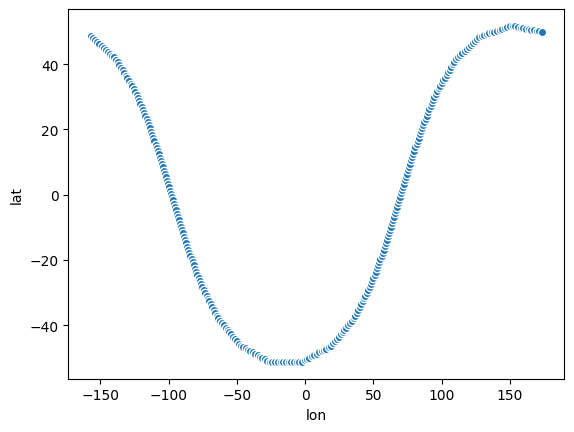

In [122]:
interpolated_data.plot.scatter(x='lon', y='lat')

<Axes: xlabel='lon', ylabel='lat'>

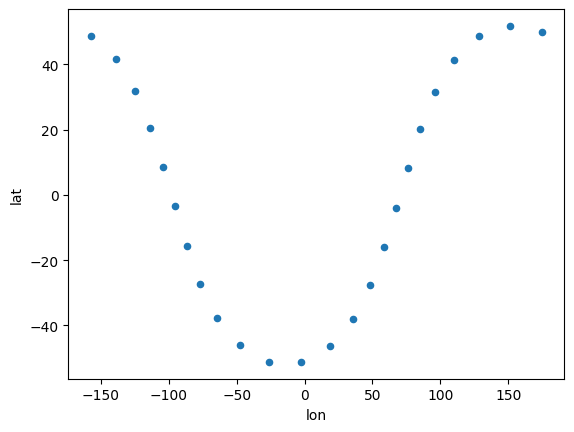

In [123]:
df_orbit.plot.scatter(x='lon', y='lat')

In [124]:
def count_orbit2(ds):
    count = 0
    temp_ds = ds['lon'].values
    print(len(temp_ds))
    for i in range(len(temp_ds)-1):
        print((temp_ds[i]), (temp_ds[i+1]))
        if (temp_ds[i] > 0) and (temp_ds[i+1] < 0):
            count += 1
            print(temp_ds[i], temp_ds[i+1])
    return count

In [125]:
count_orbit2(interpolated_data)

276
-156.89949854603924 -155.35339631524602
-155.35339631524602 -153.8072940844528
-153.8072940844528 -152.2611918536596
-152.2611918536596 -150.71508962286637
-150.71508962286637 -149.16898739207315
-149.16898739207315 -147.62288516127995
-147.62288516127995 -146.07678293048673
-146.07678293048673 -144.5306806996935
-144.5306806996935 -142.9845784689003
-142.9845784689003 -141.43847623810709
-141.43847623810709 -139.89237400731386
-139.89237400731386 -138.43972229402647
-138.43972229402647 -137.2674221332565
-137.2674221332565 -136.09512197248657
-136.09512197248657 -134.9228218117166
-134.9228218117166 -133.75052165094664
-133.75052165094664 -132.57822149017667
-132.57822149017667 -131.40592132940674
-131.40592132940674 -130.23362116863677
-130.23362116863677 -129.0613210078668
-129.0613210078668 -127.88902084709686
-127.88902084709686 -126.7167206863269
-126.7167206863269 -125.54442052555694
-125.54442052555694 -124.43593692701938
-124.43593692701938 -123.518903015179
-123.518903015

0

In [126]:
df_orbit.head(1)

,lat,lon
t,,
2024-12-12 22:44:00,48.764454,-157.286024


In [127]:
df_orbit.tail(1)

,lat,lon
t,,
2024-12-13 00:16:00,49.758868,174.777114
